<a href="https://colab.research.google.com/github/mhodki/Collaboration_network/blob/main/IOF_Maintenance_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IOF Maintenance Ontology Tutorial

## Notebook Setup

Firstly, we need to clone the materials from the Paper Archice Maintenance Activity repository on Github. This contains the MWO data, reference ontology for maintenance activity terms, an application-level ontology for identifying data quality issues in MWOs, a script to populate the ontology with MWO data, and a reasoning script.

In [1]:
!git clone https://github.com/uwasystemhealth/Paper_Archive_Maintenance_Activity.git

Cloning into 'Paper_Archive_Maintenance_Activity'...
remote: Enumerating objects: 845, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 845 (delta 148), reused 178 (delta 123), pack-reused 630
Receiving objects: 100% (845/845), 1.78 MiB | 3.42 MiB/s, done.
Resolving deltas: 100% (651/651), done.


Also import the required packages. This tutorial uses owlready to interface with the maintenance ontologies.

In [2]:
%%capture
%pip install OwlReady2
from owlready2 import *
import pandas as pd
from datetime import date
from numpy import place
import dateutil.parser as parser
from typing import List
import subprocess
import os
import sys


### MWO Data

The load_data function uses the pandas library to read the MWO data from an Excel sheet into a DataFrame.

In [3]:
def load_data(input_data_sheet_path):
    # Read excel data into dataframe
    df = pd.read_excel(input_data_sheet_path)
    print('Sucessfully loaded data')
    return df

In [4]:
input_data_sheet_path = "/content/Paper_Archive_Maintenance_Activity/population_script/data.xlsx"

data_frame = load_data(input_data_sheet_path)

data_frame.head()

Sucessfully loaded data


,ID,Date,Unstructured Text,NLP Identified Item,NLP Identified Activity,NLP Identified Subunit,Work Order Type,Labor Cost,Material Cost,Correct Class (from logic tree)
0,1,2012-10-18,pressure switch undersize,pressure switch,none,control and monitoring,corrective,560.96,821.74,repair/replace
1,2,2013-02-14,remove pressure switch,pressure switch,remove,control and monitoring,corrective,1292.13,711.11,repair/replace
2,3,2013-03-19,calibrate pressure switch,pressure switch,calibrate,control and monitoring,corrective,413.48,0.00,adjust/ calibrate
3,4,2013-04-29,pump not pumping well,pump,none,pump unit,corrective,516.85,0.00,diagnose
4,5,2013-05-21,pressure switch leaking,pressure switch,none,control and monitoring,corrective,560.96,700.00,repair/ replace


(Taken from paper)

The dataframe above contains a set of MWOs for a single functional location for a single pump in a process plant from 2012-2020. There are hundreds of other similar pumps in this facility.

Columns 2-3 and 6-8 are representative of a data set a reliability engineer would normally work with. These fields are usually of most interest to the reliability engineer and are often the most readily available as reports downloadable as CSV files from the computerised maintenance management system (CMMS). The first column contains an ID to assist us with discussions of the data set and the analysis thereof. The second column contains a date, in this case we have selected the date on which the work was started. The third column contains the unstructured text describing the work and is subject to natural language processing.  The sixth column describes the work order type as either corrective or preventative and the final two columns contain the labour and material costs; referring to Table~\ref{tab:MWOrecord}, only one of labour hours or labour costs is required, in this case the records include cost, while material cost is equivalent to the actual parts cost.

### Reference Ontology

The reference ontology is implemented in OWL and contains the seven core activities that are typically performed in maintenance; adjust, calibrate, diagnose, inspect, repair, replace, and service.

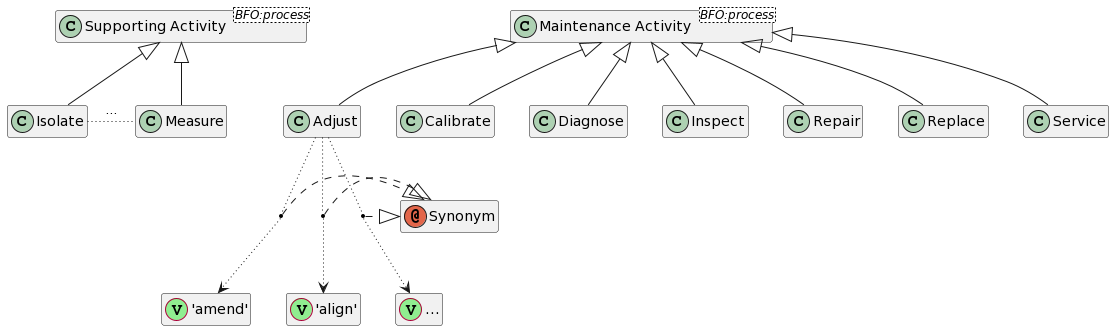

### Application-level Ontology

The purpose of the application level ontology is to demonstrate the use of the reference ontology in a real-world industrial case of MWO data quality. For data quality purposes, the goal is to determine if the activity terms classified by the ontology is consistent with activity term classified manually by a subject matter expert based on information in the MWO.

The application-level ontology consists of a set of modular, inter-operable ontologies:

1.   **Data:**

 Contains individuals extracted from MWO data

2.   **Maintenance Activity Classification Rules:**

  Contains SWRL rules, and additional activity classifiers, used to perform activity classifications

3.   **Work Order Ontology:**

  Contains notions related to MWOs (i.e. Maintenance Work Order Record, Maintenance Work Order Record Data Item, Work Order Execution Process)

4.   **Functional Breakdown Pump Ontology:**

  Imports the assets contained in the Asset List Ontology and divides them into into the subunits shown in Table 4.

5.   **Asset List:**

  Contains a list of material artifact classes in a centrifugal pump (e.g. Mechanical Seal).
  
6.   **Maintenance Activity Reference Ontology:**

  The reference ontology for maintenance activities

7.   **IOF Core Ontology:**

  The IOF Core Reference Ontology

8.   **IOF Annotation Vocabularly Ontology:**

  The IOF Annotation Vocabulary (includes Synonym, for example) Ontology

9.   **BFO:**

  The Basic Formal Ontology, used as a foundational ontology

The diagram below explains the import structure of the application level ontology.


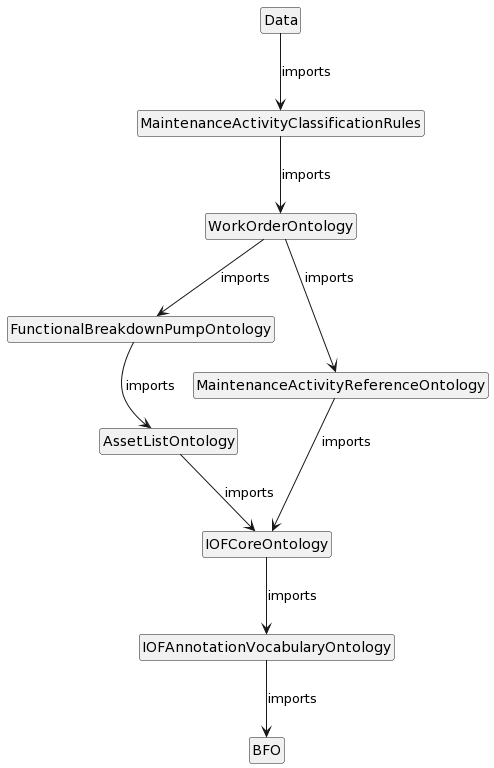

## Populate Ontology with MWO Data

The first step to addressing the use case is to populate the application ontology with the MWO data.

### Setup Enviroment

Global variables are initialized to store references to the set of ontologies and their namespaces. These will be used throughout the notebook for ontology manipulation.

Pump_number is set to '001', indicating the pump number being processed in our use case.

In [5]:
# Set global ontology variables

bfo_onto = None
iof_annotation_onto = None
iof_core_onto = None
functional_breakdown_onto = None
asset_list_onto = None
maintenance_activity_onto = None
work_order_onto = None
maint_activity_classification_rules_onto = None
onto = None

# Set ontology namsepaces
obo = None
mar = None
al = None
fb = None
ma = None
owl = None
wo = None
core = None

# Pump number in our use case
pump_number = '001'

### Loading Ontologies
The load_ontology function is responsible for loading the set of ontologies and establishing their namespaces.

Firstly, however, we must change directories into the population directory.

In [6]:
# Specify the directory containing the runner.py script
directory_path = "/content/Paper_Archive_Maintenance_Activity/population_script/"

# Change the current working directory
os.chdir(directory_path)

In [7]:
def load_ontology():
    global bfo_onto, iof_annotation_onto, iof_core_onto, functional_breakdown_onto, asset_list_onto, maintenance_activity_onto, work_order_onto, maint_activity_classification_rules_onto, onto
    global obo, mar, ma, fb, al, owl, wo, core

    # Path to ontology files
    onto_path.append('../imports')

    # Load ontologies
    bfo_onto = get_ontology("bfo-v2.owl").load()
    iof_annotation_onto = get_ontology("IOF_AnnotationsVocabulary.rdf").load()
    iof_core_onto = get_ontology("IOF.owl").load()
    onto_path.append('../')
    asset_list_onto = get_ontology("asset-list-ontology.owl").load()
    functional_breakdown_onto = get_ontology("functional-breakdown-pump-ontology.owl").load()
    work_order_onto = get_ontology("work-order-ontology.owl").load()
    maintenance_activity_onto = get_ontology("maintenance-activity.owl").load()
    maint_activity_classification_rules_onto = get_ontology("activity-classification-rules.owl").load()
    # onto = None
    onto = get_ontology("asset-data.owl").load()

    # Set up namespaces
    obo = bfo_onto.get_namespace("http://purl.obolibrary.org/obo/")
    mar = onto.get_namespace("http://www.semanticweb.org/maintenance-activity-classification-rules#")
    al = asset_list_onto.get_namespace('http://www.semanticweb.org/asset-list-ontology#')
    fb = functional_breakdown_onto.get_namespace('http://www.semanticweb.org/functional-breakdown-pump-ontology#')
    ma = maintenance_activity_onto.get_namespace('http://www.semanticweb.org/maintenance-activity#')
    owl = onto.get_namespace('http://www.w3.org/2002/07/owl#')
    wo = work_order_onto.get_namespace('http://www.semanticweb.org/work-order-ontology#')
    core = iof_core_onto.get_namespace('http://www.industrialontologies.org/core/')
    print('Sucessfully loaded ontologies and set namespaces!')


In [8]:
load_ontology()

Sucessfully loaded ontologies and set namespaces!


### Populating the Ontology

The populate_single() function populates the ontology with data from a single MWO. It relies on various helper functions to retrieve or create ontology individuals for work order details (date, description, functional location, etc.).

#### Helper Functions


In [9]:
def select_sub_unit(sub_unit):
    individual_map = [
        ['control and monitoring', 'pump_'+pump_number+'_control_and_monitoring'],
        ['lubrication', 'pump_'+pump_number+'_lub_system'],
        ['pump unit', 'pump_'+pump_number+'unit'],
        ['driver and electrical', 'pump_'+pump_number+'_driver_system'],
        ['power transmission', 'pump_'+pump_number+'_power_transmission'],
        ['piping and valves', 'pump_'+pump_number+'_piping_system'],
    ]
    # get first column from 2d array
    index = [x[0] for x in individual_map].index(sub_unit)
    return individual_map[index][1]


def select_item(item):
    individual_map = [
        ['oil', 'oil_'+pump_number],
        ['flowmeter', 'flow_meter_'+pump_number],
        ['pump', 'pump_'+pump_number],
        ['pressure switch', 'pressure_switch_'+pump_number],
        ['valve', 'valve_'+pump_number],
        ['motor', 'motor_'+pump_number],
        ['mechanical seal', 'seal_'+pump_number],
    ]
    index = [x[0] for x in individual_map].index(item)
    return individual_map[index][1]


def add_work_order_started_date_individual(row, mwo_name):
    date_name = mwo_name+"_started_date"
    input_date = parser.parse(row['Date']).isoformat()
    date_value = ""
    date_value = datetime.datetime.strptime(input_date, "%Y-%m-%dT%H:%M:%S")
    with onto:
        date = wo.WorkOrderStartedDate(date_name)
        date.hasValue.append(date_value)
        return date


def add_work_order_description_individual(row, mwo_name):
    description_name = mwo_name+"_description"
    description_value = row['Unstructured Text']
    with onto:
        description = wo.WorkOrderDescriptionText(description_name)
        description.hasValue.append(description_value)
        description.nlpIdentifiedActivity.append(
            row['NLP Identified Activity'])
        item_string = format_item(row['NLP Identified Item'])
        description.nlpIdentifiedItem.append(al[item_string])
        sub_unit_string = format_item(row['NLP Identified Subunit']) + "System"
        description.nlpIdentifiedSubunit.append(fb[sub_unit_string])
    return description


def format_item(item_string):
    return "".join(x.capitalize() or ' ' for x in item_string.split(" "))


def add_functional_location_tag_individual(row, mwo_name, item):
    functional_location_tag_name = mwo_name+"_functional_location_tag"
    with onto:
        functional_location_tag = wo.WorkOrderFunctionalLocationTag(
            functional_location_tag_name)
        functional_location_tag.hasValue.append('PU001')
        functional_location_tag.refersTo.append(onto[item])
        return functional_location_tag


def add_labour_cost(row, mwo_name):
    labour_cost_name = mwo_name+"_labour_cost"
    labour_cost_value = int(row['Labor Cost'])
    with onto:
        labour_cost = wo.WorkOrderLabourCost(labour_cost_name)
        labour_cost.hasValue.append(labour_cost_value)
        return labour_cost


def add_material_cost(row, mwo_name):
    material_cost_name = mwo_name+"_material_cost"
    material_cost_value = int(row['Material Cost'])
    with onto:
        material_cost = wo.WorkOrderMaterialCost(material_cost_name)
        material_cost.hasValue.append(material_cost_value)
        return material_cost


def add_maintenance_type(row, mwo_name):
    maintenance_type_name = mwo_name+"_maintenance_type"
    maintenance_type_value = row['Work Order Type']
    with onto:
        maintenance_type_value_string = 'WorkOrder' + \
            maintenance_type_value.capitalize() + 'Maintenance'
        maintenance_type = wo.WorkOrderMaintenanceType(
            maintenance_type_name)
        maintenance_type = wo[maintenance_type_value_string](
            maintenance_type_name)
        return maintenance_type


def add_activity_individual(row, mwo_name):
    activity_name = mwo_name+"_activity"
    with onto:
        activity = owl.Thing(activity_name)
        activity.is_a.append(
            Or([ma.MaintenanceActivity, ma.SupportingActivity]))
        # hack to create activity without owl:Thing
        activity.is_a.remove(activity.is_a[0])
        return activity


def add_wo_execution_event(row, mwo_name, activity, item):
    wo_execution_event_name = mwo_name+"_wo_execution_event"
    with onto:
        wo_execution_event = wo.WorkOrderExecutionProcess(
            wo_execution_event_name)
        wo_execution_event.BFO_0000117.append(activity)
        wo_execution_event.BFO_0000057.append(onto[item])
        return wo_execution_event

#### Populate MWO function

The following creates a data object in OWLReady using the data formatted in the previous section. Later on OWLReady converts this data object to an OWL file.

In [10]:
def populate_single(index, row):

    print(f'Populating MWO {index}')
    # sub_unit_indiv = select_sub_unit(row['NLP Identified Subunit'])
    item_indiv = select_item(row['NLP Identified Item'])

    mwo_name = "MWO-"+str(row['ID'])
    date = add_work_order_started_date_individual(row, mwo_name)
    work_order = add_work_order_description_individual(row, mwo_name)
    func_loc = add_functional_location_tag_individual(
        row, mwo_name, select_item('pump'))
    labor = add_labour_cost(row, mwo_name)
    material = add_material_cost(row, mwo_name)
    maint_type = add_maintenance_type(row, mwo_name)
    activity = add_activity_individual(row, mwo_name)
    wo_execution_event = add_wo_execution_event(
        row, mwo_name, activity, item_indiv)

    with onto:
        mwo = wo.MaintenanceWorkOrderRecord(mwo_name)
        AllDifferent([mwo, date, work_order, func_loc, labor,
                      material, maint_type, activity, wo_execution_event])
        mwo.hasDataField.append(date)
        mwo.hasDataField.append(work_order)
        mwo.hasDataField.append(func_loc)
        mwo.hasDataField.append(labor)
        mwo.hasDataField.append(material)
        mwo.hasDataField.append(maint_type)
        mwo.describes.append(activity)
        mwo.describes.append(wo_execution_event)
        mwo.isInputOfAtSomeTime.append(wo_execution_event)

    print(f'Sucessfully populated MWO {index}')

For the sake of time we will just populate a singular MWO, but you could run the function in a loop to populate with entries in the excel sheet.

In [36]:
mwo_num = 1;
mwo_entry = data_frame.iloc[mwo_num]
populate_single(mwo_num, mwo_entry)

Populating MWO 1
Sucessfully populated MWO 1


### Save the ontology

The final step is to save the instantiated MWO ontology to a file in RDF/XML serialisation of an OWL file.

In [37]:
def save_ontology(filename, save_merged=False):
    ont_to_save = owlready2.default_world if save_merged else onto
    ont_to_save.save(file=filename, format="rdfxml")
    print(f'Sucessfully saved {filename}')

In [38]:
save_ontology("../data/tutorial-example-" + str(mwo_num) + ".owl", True)

Sucessfully saved ../data/tutorial-example-1.owl


### Populated MWO

In [39]:
onto = get_ontology("../data/tutorial-example-0.owl").load()


The following command allows you to see all individuals in the ontology and its imports. The word before the . indicates the ontology the individual is from.

In [40]:
for i in list(Thing.instances()):
  print(i)

maintenance-activity.measure
asset-data.flow_meter_001
asset-data.motor_001
asset-data.oil_001
asset-data.pressure_switch_001
asset-data.pump_001
asset-data.pump_001_control_system
asset-data.pump_001_driver_system
asset-data.pump_001_lub_system
asset-data.pump_001_piping_system
asset-data.pump_001_unit
asset-data.valve_001
asset-data.seal_001
asset-data.MWO-1_started_date
asset-data.MWO-1_description
asset-data.MWO-1_functional_location_tag
asset-data.MWO-1_labour_cost
asset-data.MWO-1_material_cost
asset-data.MWO-1_maintenance_type
asset-data.MWO-1_activity
asset-data.MWO-1_wo_execution_event
asset-data.MWO-1
maintenance-activity.measure
asset-data.flow_meter_001
asset-data.motor_001
asset-data.oil_001
asset-data.pressure_switch_001
asset-data.pump_001
asset-data.pump_001_control_system
asset-data.pump_001_driver_system
asset-data.pump_001_lub_system
asset-data.pump_001_piping_system
asset-data.pump_001_unit
asset-data.valve_001
asset-data.seal_001
asset-data.MWO-1_started_date
asset

## Population Script

Alternatively, just run the provided script to automatically populate the MWOs in the excel sheet. The scripts for this are in the GitHub folder called population_script. This will allow users to run the command directly in a terminal.

In [ ]:
command = "python runner.py %s %s" % (1, True)
result = subprocess.run(command, shell=True, capture_output=True, text=True)
print("Output:", result.stdout)

Output: Starting Population Script
loaded
populating index + 0
Starting Population Script
loaded
populating index + 1
Starting Population Script
loaded
populating index + 2
Starting Population Script
loaded
populating index + 3
Starting Population Script
loaded
populating index + 4
Starting Population Script
loaded
populating index + 5
Starting Population Script
loaded
populating index + 6
Starting Population Script
loaded
populating index + 7
Starting Population Script
loaded
populating index + 8
Starting Population Script
loaded
populating index + 9
Starting Population Script
loaded
populating index + 10
Starting Population Script
loaded
populating index + 11
Starting Population Script
loaded
populating index + 12
Starting Population Script
loaded
populating index + 13
Starting Population Script
loaded
populating index + 14
Starting Population Script
loaded
populating index + 15
Starting Population Script
loaded
populating index + 16
Starting Population Script
loaded
populating index

## Reasoning Across Instance Data

The quality of MWO  data is an unsolved problem that is imperative for downstream statistical tasks such as mean-time-to-failure analyses. However, maintenance engineers rarely spend time checking the quality of this data, as there is no widely-accepted, repeatable manner to perform this task. The application ontology uses SWRL rules and ontological classification to provide a structured and repeatable way for organisations to assess the quality of maintenance work orders that reflects the logic currently used by engineers performing this task in industry.


(taken from paper)

### Setup Enviroment

In [41]:
# Set Java memory for reasoning
owlready2.reasoning.JAVA_MEMORY = 4000

# Specify ontology paths
onto_path.append('../imports')
onto_path.append('../data')
onto_path.append('../')

classifications = []
non_matching = []
records = []

# Initialize Owlready2 World
the_world = World()

### Load MWO Instance

For the purpose of time efficiency, we will only run the reasoning across the singular instantiated MWO ontology.

In [42]:
# Load ontology for the current record
onto = the_world.get_ontology(
    "../data/tutorial-example-0.owl").load(only_local=True)
    # "../data/populated-data-0.owl").load(only_local=True)


# Define namespaces
data = onto.get_namespace('http://www.semanticweb.org/data#')
rules = onto.get_namespace(
    'http://www.semanticweb.org/maintenance-activity-classification-rules#')
activity = onto.get_namespace(
    'http://www.semanticweb.org/maintenance-activity#')
work_order = onto.get_namespace(
    'http://www.semanticweb.org/work-order-ontology#')
func_breakdown = onto.get_namespace(
    'http://www.semanticweb.org/functional-breakdown-pump-ontology#')
asset_classes = onto.get_namespace(
    'http://www.semanticweb.org/asset-list-ontology#')

### Perform reasoning

The Pellet reasoner from the python owlready2 library is used. There can be some inconsistency in the output occasionally (exact cause is unknown) where the activity classifications are not inferred and so we will run the pellet reasoner twice if it detects such an occurrence.
The reasoner is determining the activity type.

In [43]:
with onto:
  sync_reasoner_pellet(the_world, infer_property_values=True,
                        infer_data_property_values=True)

  # Retry reasoning if not successful
  if len(data['MWO-1_activity'].is_a) <= 2:
      sync_reasoner_pellet(the_world, infer_property_values=True,
                            infer_data_property_values=True)

* Owlready2 * Running Pellet...
    java -Xmx4000M -cp /usr/local/lib/python3.10/dist-packages/owlready2/pellet/pellet-2.3.1.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/log4j-api-2.19.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/httpclient-4.2.3.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/xercesImpl-2.10.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/jena-arq-2.10.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/jena-tdb-0.10.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/commons-codec-1.6.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/slf4j-log4j12-1.6.4.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/log4j-core-2.19.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/jena-core-2.10.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/slf4j-api-1.6.4.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/xml-apis-1.4.01.jar:/usr/local/

### Post-Reasoning Queries

#### SPARQL Query for Non-Matching Activity Types

In [44]:
def query_not_matching(world):
    """SPARQL query to find non-matching activity types"""

    query = """
    PREFIX core:<http://www.industrialontologies.org/core/>
    PREFIX activity:<http://www.semanticweb.org/maintenance-activity#>
    PREFIX work:<http://www.semanticweb.org/work-order-ontology#>
    PREFIX macr:<http://www.semanticweb.org/maintenance-activity-classification-rules#>
    SELECT DISTINCT ?activity ?clazz ?nlpActivityType
    WHERE {
        ?activity a/rdfs:subClassOf* macr:InferredActivity ;
            a ?clazz .
        FILTER isIRI( ?clazz )
        FILTER ( ?clazz != macr:InferredActivity && ?clazz != macr:UncertainActivity && ?clazz != macr:MaintenanceSupportingOrUnspecifiedActivity )
        FILTER NOT EXISTS { ?activity a/rdfs:subClassOf* macr:InferredActivityTypeMatchesWorkOrderDescription }
        OPTIONAL {
            ?activity core:describedBy|^core:describes ?_record .
            ?_record work:refersTo ?nlpActivityType .
            ?nlpActivityType rdfs:subClassOf+ activity:MaintenanceActivity .
        }
    }
    """
    results = world.sparql(query)
    # filter the extraneous references to the number '12'
    return [r for r in results if not isinstance(r[1], int)]

#### SPARQL Query for Records and Classifications

In [25]:
def query_records_and_classifications(world):
    """
    SPARQL query for retreiving the record details plus the resolved activity type and activity classification
    """

    query = """
    PREFIX core:<http://www.industrialontologies.org/core/>
    PREFIX activity:<http://www.semanticweb.org/maintenance-activity#>
    PREFIX work:<http://www.semanticweb.org/work-order-ontology#>
    PREFIX macr:<http://www.semanticweb.org/maintenance-activity-classification-rules#>
    SELECT DISTINCT ?record ?tag_name ?tagged_item ?text ?activity ?item ?unit ?labour_cost ?material_cost ?date_time ?maint_type ?activityType ?nlpActivityRef
    WHERE {
        ?record a work:MaintenanceWorkOrderRecord ;
            work:hasDataField ?_tag ;
            work:hasDataField ?description ;
            work:hasDataField ?labour ;
            work:hasDataField ?material ;
            work:hasDataField ?date ;
            work:hasDataField ?_maint_type .
        ?_tag a work:WorkOrderFunctionalLocationTag ;
            work:refersTo ?tagged_item .
        OPTIONAL {
            ?_tag work:hasValue ?tag_name ;
        }
        ?description a work:WorkOrderDescriptionText ;
            work:hasValue ?text ;
            macr:nlpIdentifiedActivity ?activity ;
            macr:nlpIdentifiedItem ?item ;
            macr:nlpIdentifiedSubunit ?unit .
        ?labour a work:WorkOrderLabourCost ;
            work:hasValue ?labour_cost .
        ?material a work:WorkOrderMaterialCost ;
            work:hasValue ?material_cost .
        ?date a work:WorkOrderStartedDate ;
            work:hasValue ?date_time .
        ?_maint_type a work:WorkOrderMaintenanceType ;
            a ?maint_type .
        ?maint_type rdfs:subClassOf work:WorkOrderMaintenanceType .
        OPTIONAL {
            ?record core:describes ?_activity .
            ?_activity a ?activityType .
            ?activityType rdfs:subClassOf+ activity:MaintenanceActivity .
        }
        OPTIONAL {
            ?description work:refersTo ?nlpActivityRef .
            ?nlpActivityRef rdfs:subClassOf+ activity:MaintenanceActivity .
        }
    }
    """
    results = world.sparql(query)
    return list(results)

### Running the Queries

In [26]:
def simplify_results(results: List[List[ThingClass]]) -> List[List[str]]:
    """Reduces the owlready2 objects to short name strings"""
    return [[o.name if hasattr(o, 'name') else str(o) for o in r] for r in results]

In [27]:
# Query non-matching activities
i_results = query_not_matching(the_world)
non_matching.extend(simplify_results(i_results))

# Query records and classifications
r_results = query_records_and_classifications(the_world)
records.extend(simplify_results(r_results))

# Extract and store classifiers
classifiers = simplify_results([data[f'MWO-1_activity'].is_a])
classifications.append((f'MWO-1_activity', classifiers[0]))

# Print results
print('= All Activity Classifications')
print('  id, list of classifiers (including anonymous)')
print("\n".join([str(c) for c in classifications]), end="\n\n")

print('= Activity classifications not matching Activity Term from text')
print('  activity id, shortened classifier, term')
print("\n".join([str(n) for n in non_matching]), end="\n\n")

print('= MWO Records with Activity Classifications')
print('  ?record, ?tag_name, ?tagged_item, ?text, ?activity, ?item, ?unit, ?labour_cost, ?material_cost, ?date_time, ?maint_type, ?activityType, ?nlpActivityRef')
print("\n".join([str(r) for r in records]))


= All Activity Classifications
  id, list of classifiers (including anonymous)
('MWO-1_activity', ['UncertainActivity', 'RepairOrReplace', 'maintenance-activity.MaintenanceActivity | maintenance-activity.SupportingActivity'])

= Activity classifications not matching Activity Term from text
  activity id, shortened classifier, term
['MWO-1_activity', 'NamedIndividual', 'None']
['MWO-1_activity', 'RepairOrReplace', 'None']

= MWO Records with Activity Classifications
  ?record, ?tag_name, ?tagged_item, ?text, ?activity, ?item, ?unit, ?labour_cost, ?material_cost, ?date_time, ?maint_type, ?activityType, ?nlpActivityRef
['MWO-1', 'PU001', 'pump_001', 'pressure switch undersize', 'none', 'PressureSwitch', 'ControlAndMonitoringSystem', '560', '821', '2012-10-18 00:00:00', 'WorkOrderCorrectiveMaintenance', 'RepairOrReplace', 'None']


## Reasoning Script

Alternatively, you can just run the provided script to automatically perform reasoning across the MWOs in the excel sheet.

The reasoning script can be run across all records, and individual record, or some subset of records. For example, running the command


```
python runner.py
```


will run the full set (1-36), while


```
python runner.py 3 12
```

will run the third to twelfth records. The last argument can be omitted to run until the end, e.g., third to 36th record if omitted from the above example. Finally, the following would run only the second record:

```
python runner.py 2 2
```

In [ ]:
# Specify the directory containing the runner.py script
directory_path = "/content/Paper_Archive_Maintenance_Activity/reasoning_script/"

# Change the current working directory
os.chdir(directory_path)

In [ ]:
command = "python runner.py %s %s" % (1, 1)
result = subprocess.run(command, shell=True, capture_output=True, text=True)
print("Output:", result.stdout)